<a href="https://colab.research.google.com/github/DulanMahesh/ComputerVision/blob/main/ML_02_Regression_with_Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1 style="font-size:30px;">Linear Regression to Deep Learning using Keras</h1>

In this notebook, we will continue with the topic of linear regression, and we will work with a dataset that contains multiple input features. We will demonstrate how linear regression can be modeled in Keras as a linear neural network with multiple input features. This will be accomplished with a single layer neural network containing just a single neuron. Next, we will explore how adding hidden layers in the network with non-linear activation functions will produce a non-linear response.  This notebook is partially based on a tutorial available on the Tensorflow website and we’ve provided that link as a reference for you [here](https://www.tensorflow.org/tutorials/keras/regression).

<img src='https://learnopencv.com/wp-content/uploads/2022/01/c4_02_regression_3D_plots.jpg' width=950 align='left'><br/>

## Table of Contents

* [1 Load and Pre-Process the Auto MPG Dataset](#1-Load-and-Explore-the-Auto-MPG-Dataset)
* [2 Keras Training Workflow](#2-Keras-Training-Workflow)
* [3 Linear Regression](#3-Linear-Regression)
* [4 Multivariate Linear Regression](#4-Multivariate-Linear-Regression)
* [5 Deep Learning with a Single Feature](#5-Deep-Learning-with-a-Single-Feature)
* [6 Deep Learning with Multiple Features](#6-Deep-Learning-with-Multiple-Features)
* [7 Comparison of Test Results](#7-Comparison-of-Test-Results)
* [8 Conclusion](#8-Conclusion)

In [4]:
import os
import math
import numpy as np
from numpy import loadtxt
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow as tf
import seaborn as sns
import pandas as pd

plt.rcParams["figure.figsize"] = (15, 6)
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 12



In [5]:
SEED_VALUE = 42

# Fix seed to make training deterministic.
np.random.seed(SEED_VALUE)
tf.random.set_seed(SEED_VALUE)

# For GPU.
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["TF_CUDNN_DETERMINISTIC"] = "1"

## 1 Load and Pre-Process the Auto MPG Dataset

In this notebook, we will be working with the Auto MPG dataset from the UC Irvine machine learning repository [here](https://archive.ics.uci.edu/ml/datasets.php). This data set contains nearly 400 samples of automobile data from the 1970s. There are eight data fields in the dataset consisting of various attributes such as vehicle weight and horsepower, and the goal is to use these features to predict the vehicle MPG.

In [6]:

dataset_name = 'auto-mpg.data'
dataset_url  = 'https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
dataset_path = keras.utils.get_file(dataset_name, dataset_url)
print('dataset_path: ', dataset_path)

dataset_path = '~/.keras/datasets/auto-mpg.data'

column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin']

# Load the dataset into a Pandas data frame.
raw_dataset = pd.read_csv(dataset_path, names=column_names, na_values="?", comment='\t',
                          sep=" ", skipinitialspace=True)

dataset = raw_dataset.copy()
dataset.tail()

      0/Unknown 0s 0s/stepdataset_path:  /root/.keras/datasets/auto-mpg.data


,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


### 1.1 Clean the Dataset

In [7]:
dataset.isna().sum()

,0
MPG,0
Cylinders,0
Displacement,0
Horsepower,6
Weight,0
Acceleration,0
Model Year,0
Origin,0


In [8]:
# Use the dropna() method to remove data samples that are not fully populated.
dataset = dataset.dropna()
dataset.shape

(392, 8)

### 1.2 Split the Dataset into Train and Test

Let's now split the dataset into test and train components so we can train some models and evaluate them.

In [9]:
train_dataset = dataset.sample(frac=0.8, random_state=42)
test_dataset = dataset.drop(train_dataset.index)

print(train_dataset.shape)
print(test_dataset.shape)

train_dataset

(314, 8)
(78, 8)


,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
79,26.0,4,96.0,69.0,2189.0,18.0,72,2
276,21.6,4,121.0,115.0,2795.0,15.7,78,2
248,36.1,4,91.0,60.0,1800.0,16.4,78,3
56,26.0,4,91.0,70.0,1955.0,20.5,71,1
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
...,...,...,...,...,...,...,...,...
218,36.0,4,79.0,58.0,1825.0,18.6,77,2
281,19.8,6,200.0,85.0,2990.0,18.2,79,1
342,30.0,4,135.0,84.0,2385.0,12.9,81,1
238,33.5,4,98.0,83.0,2075.0,15.9,77,1


### 1.3 Split the Features from Target Values

Since the features and the target value are contained in the same dataframe we will separate them into two dataframes to keep them isolated. This also makes it easier to manage the data.

In [10]:
X_train = train_dataset.copy()
X_test  = test_dataset.copy()

# Separate target values from features.
y_train = X_train.pop('MPG')
y_test  = X_test.pop('MPG')

## 2 Keras Training Workflow

The diagram shown below summarizes the training workflow in Keras that is used to create a trained model.

<img src='https://learnopencv.com/wp-content/uploads/2022/01/c4_02_keras_training_workflow.png' width=600 align='left'><br/>


## 3 Linear Regression

In this section, we will use Keras to model a single neuron (with a linear activation) to perform linear regression using just a single input variable from the dataset. We will also demonstrate how to add a normalization layer to the network model. Specifically, we'll use 'Horsepower' as the input feature to predict the MPG of the vehicle. Thus, the model will consist of a straight line with two unknown coefficients (the slope and the intercept). We will train the model to determine the coefficients.

### 3.1 Normalize the Feature Data

Various methods can be used to scale features, but normalization and standardization are the most commonly used methods. Normalization usually refers to min/max scaling, where each feature is scaled to the range \[0, 1\] as shown below for each feature ($x_i$):

$$ x_i = \frac{x_i - min_{x_i}}{max_{x_i} - min_{x_i}}$$


Standardization (also referred to as z-score scaling) assume the original data is normally distributed and scales the feature to have zero mean and a standard deviation of 1. This is accomplished for each feature ($x_i$) by subtracting the mean from each data point (referred to as mean subtraction) and then dividing that result by the standard deviation as shown below:

$$ x_i = \frac{x_i - \mu_i}{\sigma_i}$$

As discussed in the previous notebook, Keras now provides a normalization layer that automatically performs feature-wise normalization to the input features, so we don't need to write our own functions to manage this conversion. The normalization layer will shift and scale inputs into a distribution centred around 0 with a standard deviation of 1. The name of this layer is a little confusing since the feature scaling nomenclature described in the paragraph above is fairly well established. In Keras, normalization refers to z-score scaling of the feature data.

**Note**: The normalization parameters (mean and standard deviation) are derived only from the **training** dataset, but will be applied to all of the data (train, validation and test).


In [11]:
# Convert the Horsepower feature in the dataframe to a NumPy array.
hp = np.array(X_train['Horsepower'])

# Create the normalization layer (for Horsepower).
hp_normalizer = layers.Normalization(input_shape=[1,], axis=None)

# Call the `adapt` method to apply the normalization.
hp_normalizer.adapt(hp)

print('Mean:  ', hp_normalizer.mean.numpy()[0])
print('Std:   ', math.sqrt(hp_normalizer.variance.numpy()[0]))
print('Count: ', hp_normalizer.count.numpy())

Mean:   105.97134
Std:    39.573391877959644
Count:  0


/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


### 3.2 Create Keras Model

Here we define the Keras model using the Sequential API. The figure below shows the model architecture. Note: The weight update process includes the bias term even though an update equations is not explciity shown in the figure.

<img src='https://learnopencv.com/wp-content/uploads/2022/01/c4_02_linear_regression_norm_wx_b.png' width=600 align='center'><br/>


In [12]:
# Instantiate the model.
linear_1d_model = tf.keras.Sequential()

# Add the normalization layer.
linear_1d_model.add(hp_normalizer)

# Add the single neuron.
linear_1d_model.add(Dense(1, input_shape=(1,)))

# Display the model summary.
linear_1d_model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ normalization (Normalization)        │ (None, 1)                   │               3 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │               2 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5 (24.00 B)

 Trainable params: 2 (8.00 B)

 Non-trainable params: 3 (16.00 B)

### 3.3 Compile the Model

Here we specify the loss function and the optimizer.

In [13]:
linear_1d_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mae')

### 3.4 Train the Model

It's now time to train the model using the single input feature. For this dataset and the examples in this notebook, we will be using 100 epochs. Notice that we're specifying a `validation_split` of 30%, which reserves (withholds) 30% of the training samples from being used to train the model so they can be used to evaluate the model during the training process. The `fit` method returns a `history` object that we will then be used to plot the train and validation loss curves below.

In [14]:
history_linear_1d = linear_1d_model.fit(
    X_train['Horsepower'],
    y_train,
    epochs=100,
    verbose=0,
    validation_split = 0.3)

In [15]:
hist = pd.DataFrame(history_linear_1d.history)
hist.tail()

,loss,val_loss
95,3.781940,3.853778
96,3.782648,3.851820
97,3.782531,3.851321
98,3.781387,3.853139
99,3.782154,3.853247


In [16]:
def plot_loss(history):
    plt.figure(figsize=(15,5))
    plt.plot(history.history['loss'], label='Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.ylim([0, 10])
    plt.xlabel('Epoch')
    plt.ylabel('Error [MPG]')
    plt.legend()
    plt.grid(True)

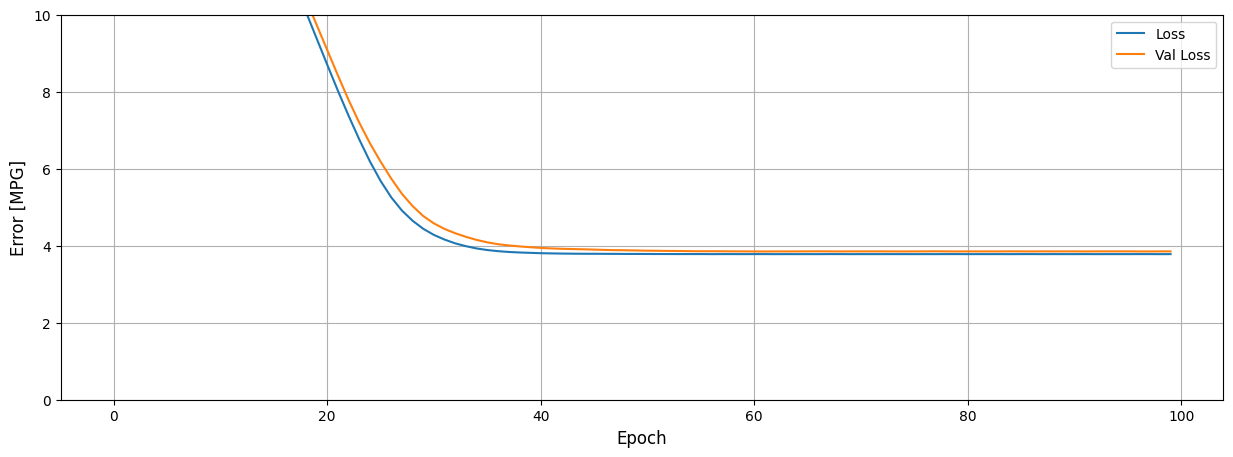

In [17]:
plot_loss(history_linear_1d)

### 3.5 Model Prediction

Once the model has been trained, we can now use the `predict()` method to predict `MPG` given a range of values for `Horsepower`.

In [18]:
# Generate feature data for Horsepower.
x = tf.linspace(0.0, 250, 251)

# Use the model to predict MPG.
y = linear_1d_model.predict(x)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


In [19]:
def plot_horsepower(x, y):
    plt.figure(figsize=(15,5))
    plt.scatter(X_train['Horsepower'], y_train, label='Data', color='green', alpha=0.5)
    plt.plot(x, y, color='k', label='Predictions')
    plt.xlabel('Horsepower')
    plt.ylabel('MPG')
    plt.grid(True)
    plt.legend()

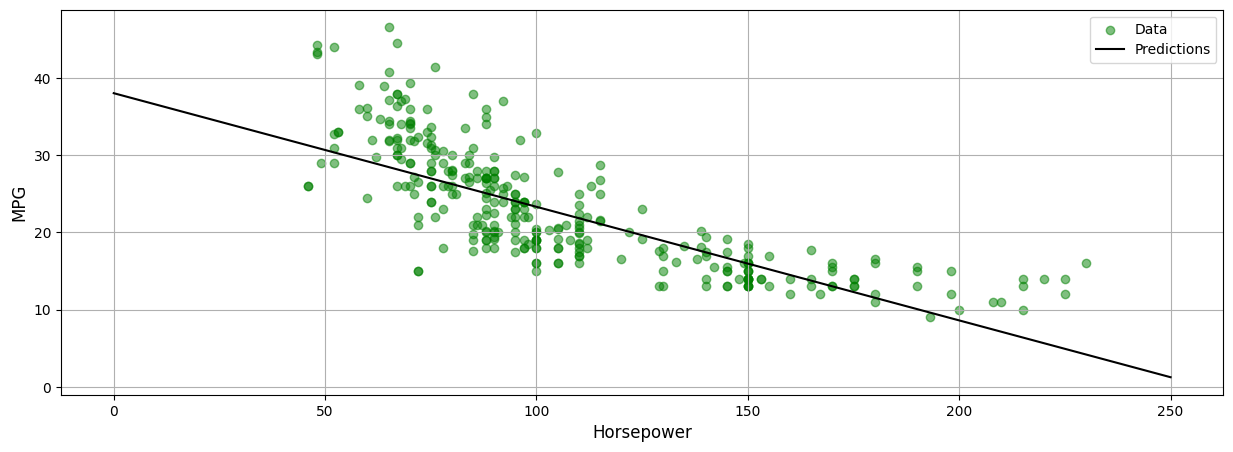

In [20]:
plot_horsepower(x,y)

In [21]:
# Non-trainable parameters.
mean     = linear_1d_model.layers[0].get_weights()[0]
variance = linear_1d_model.layers[0].get_weights()[1]
num_pts  = linear_1d_model.layers[0].get_weights()[2]
print('Horsepower Mean:  ', int(mean*1000)/1000)
print('Horsepower Std:   ', int(math.sqrt(variance)*1000)/1000)
print('Horsepower Pts:   ', num_pts)

Horsepower Mean:   105.971
Horsepower Std:    39.573
Horsepower Pts:    0


In [22]:
# Normalized weights.
slope_norm = linear_1d_model.layers[1].get_weights()[0]
y_int_norm = linear_1d_model.layers[1].get_weights()[1]

# Model parameters.
slope = slope_norm / math.sqrt(variance)
y_int = y_int_norm - mean*slope
print('Model Slope: ', slope[0][0])
print('Model Y-Int: ', y_int[0][0])

Model Slope:  -0.14723626
Model Y-Int:  38.0512


## 4 Multivariate Linear Regression

In this section, we will extend the previous example to now use two input features. All of the processing steps will remain the same. The only differences are those related to the input shape. With two input features, our model for the response variable is now a plane rather than a line. Using the general form that we introduced in Module 1, the hypothesis (function) takes the following form with two input features:

$$ h_\theta(x) = \theta_0 + \theta_1x_1 + \theta_2x_2$$

When working with neural networks, it is more common to use the notation below:

$$ y' = w_1x_1 + w_2x_2 + b$$

Since we have two inputs, we have two weights (one for each input) and then a single bias term associated with the single neuron. The equations above represent the equation of a plane in 3D space.

### 4.1 Define the Normalization Layer

In [23]:
hp_dp = np.array(X_train[['Horsepower', 'Displacement']])
print(hp_dp.shape)

# Set 'axis' to be the axis of the feature dimension. Since the input shape is (num_points, 2), we need to set
# axis=1 to indicate that each feature should be normalized. Setting axis=-1 would also work in this case
# since a -1 indicates the last axis.
hp_dp_normalizer = layers.Normalization(input_shape=[2,], axis=1)
hp_dp_normalizer.adapt(hp_dp)

mean = hp_dp_normalizer.mean.numpy()
var = hp_dp_normalizer.variance.numpy()

std_1 = int(math.sqrt(var[0][0])*1000)/1000
std_2 = int(math.sqrt(var[0][1])*1000)/1000

print('Mean:  ', mean[0][0], mean[0][1])
print('Std:   ', std_1, std_2)
print('Count: ', hp_dp_normalizer.count.numpy())

(314, 2)
Mean:   105.97134 197.8551
Std:    39.573 106.332
Count:  0


/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


### 4.2 Build the Keras Model

In [24]:
linear_2d_model = tf.keras.Sequential()
linear_2d_model.add(hp_dp_normalizer)
linear_2d_model.add(Dense(1, input_shape=(2,), activation=None))

linear_2d_model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ normalization_1 (Normalization)      │ (None, 2)                   │               5 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │               3 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8 (36.00 B)

 Trainable params: 3 (12.00 B)

 Non-trainable params: 5 (24.00 B)

### 4.3 Compile the Model

In [25]:
linear_2d_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mae')

### 4.4 Train the Model

In [26]:
history_linear_2d = linear_2d_model.fit(
    X_train[['Horsepower', 'Displacement']],
    y_train,
    epochs=100,
    verbose=0,
    validation_split = 0.3)

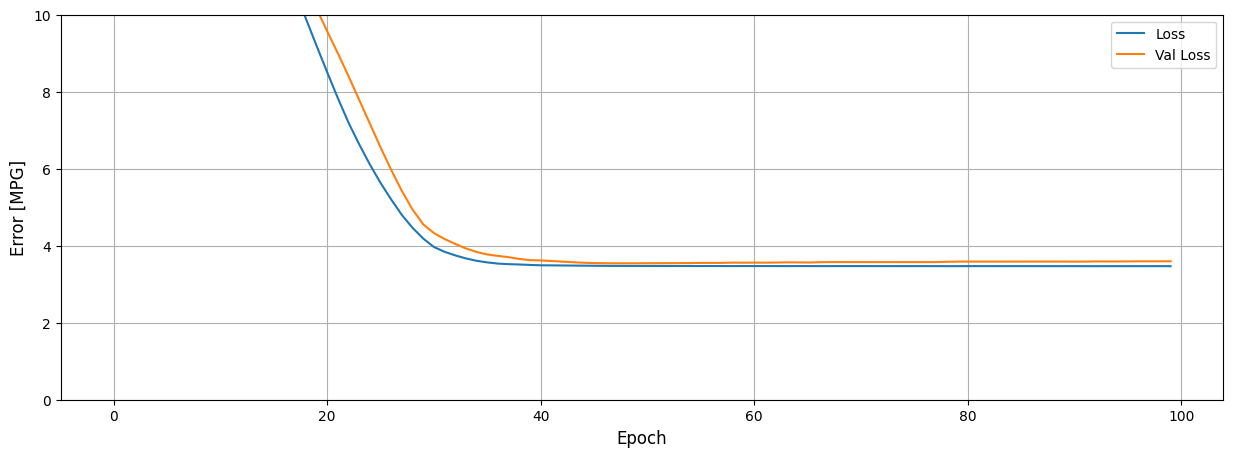

In [27]:
plot_loss(history_linear_2d)

### 4.5 Visualize the Fitted Model

In [28]:
hp_min = X_train.Horsepower.min()
hp_max = X_train.Horsepower.max()
dp_min = X_train.Displacement.min()
dp_max = X_train.Displacement.max()

x_surf, y_surf = np.meshgrid(np.linspace(hp_min, hp_max, 100), np.linspace(dp_min, dp_max, 100))
x_grid = pd.DataFrame({'Horsepower': x_surf.ravel(), 'Displacement': y_surf.ravel()})

pred_y = linear_2d_model.predict(x_grid)
pred_y = np.array(pred_y)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


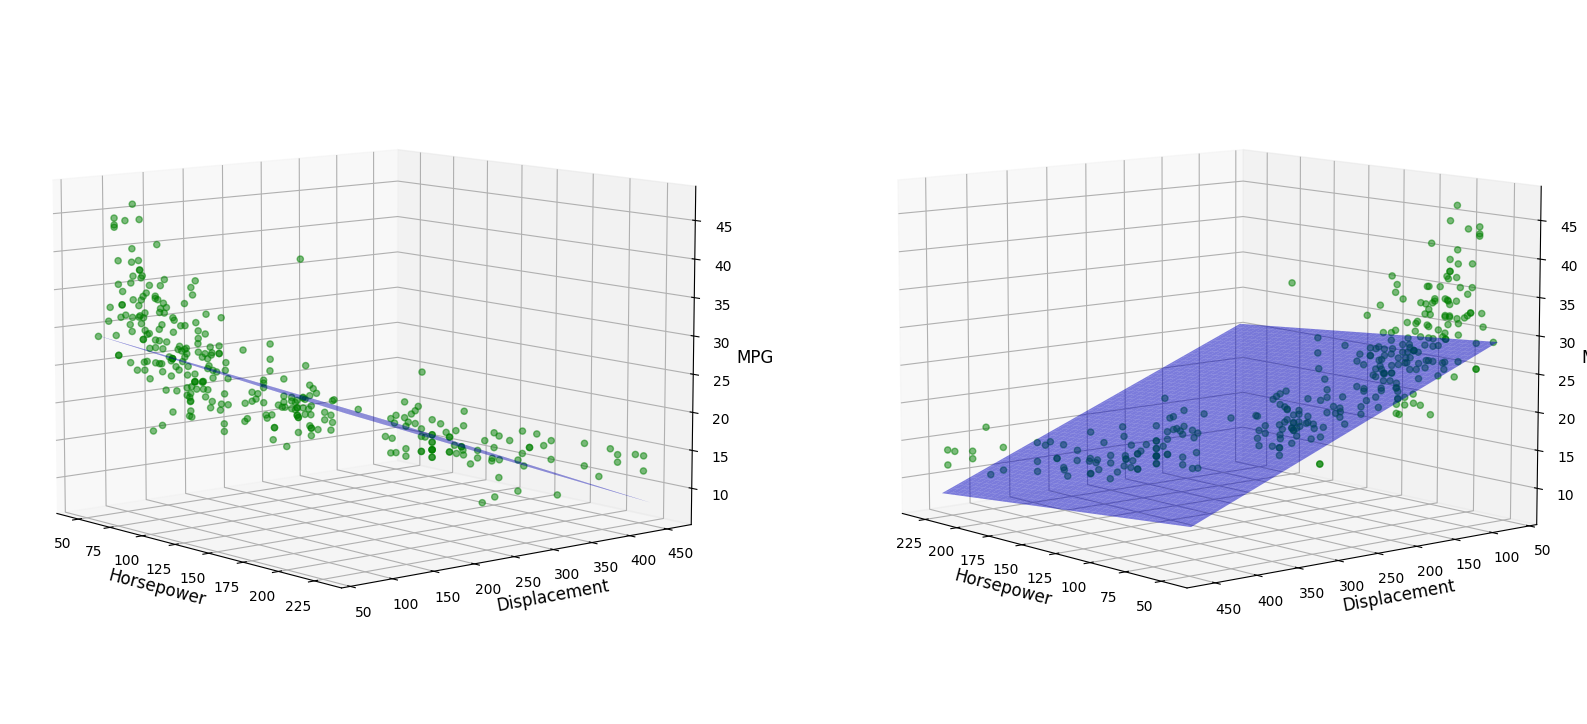

In [29]:
fig = plt.figure(figsize=(20, 10))

ax = fig.add_subplot(121, projection='3d')
ax.scatter(X_train['Horsepower'], X_train['Displacement'], y_train, c='green',  marker='o', alpha=0.5)
ax.plot_surface(x_surf, y_surf, pred_y.reshape(x_surf.shape), color='blue', alpha=0.5)
ax.set_xlabel('Horsepower')
ax.set_ylabel('Displacement')
ax.set_zlabel('MPG')
ax.view_init(9, -40)

ax = fig.add_subplot(122, projection='3d')
ax.scatter(X_train['Horsepower'], X_train['Displacement'], y_train, c='green', marker='o', alpha=0.5)
ax.plot_surface(x_surf, y_surf, pred_y.reshape(x_surf.shape), color='blue', alpha=0.5)
ax.set_xlabel('Horsepower')
ax.set_ylabel('Displacement')
ax.set_zlabel('MPG')
ax.view_init(9, 140)

## 5 Deep Learning with a Single Feature

We are now ready to model hidden layers in our network. Adding hidden layers with non-linear activation functions is what makes them "Deep" and capable of learning general non-linear functional mappings between inputs and outputs. The simplified network diagram below shows the general architecture, which consists of an input layer, two hidden layers, and the output layer. In this section, we are going to model a network like this using two input features. We will use a non-linear (`relu`) activation function in the hidden layers that will allow the network to model non-linear functions.

<img src='https://learnopencv.com/wp-content/uploads/2022/01/c4_02_DL_high_level.png' width=700 align='center'><br/>

### 5.1 Build the Keras Model

Here we are going to build a simple deep neural network with two hidden layers (each with 32 neurons). Each of the neurons in the hidden layers will use `relu` activation functions. The choice of two hidden layers and 32 neurons for each layer is rather arbitrary, but we will need at least one hidden layer to model a non-linear response.

In [30]:
# Build the model in Keras.
dnn_1d_model = tf.keras.Sequential()
dnn_1d_model.add(hp_normalizer)                 # Previoulsy defined.
dnn_1d_model.add(Dense(32, activation='relu'))
dnn_1d_model.add(Dense(32, activation='relu'))
dnn_1d_model.add(Dense(1, activation=None))
dnn_1d_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ normalization (Normalization)        │ (None, 1)                   │               3 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │              64 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,156 (4.52 KB)

 Trainable params: 1,153 (4.50 KB)

 Non-trainable params: 3 (16.00 B)

Display the initial values for the weights and biases in the first hidden layer.

In [31]:
hidden_1 = dnn_1d_model.layers[1]
weights, biases = hidden_1.get_weights()
print(weights)
print('\n')
print(biases)

[[-0.19357355  0.32848954 -0.22558376 -0.02115995  0.23847449  0.06269282
   0.04155111 -0.20499435  0.2060197  -0.10454404 -0.23524003 -0.07339683
  -0.04000553  0.00607714 -0.3182801   0.2769994   0.32172757  0.269531
  -0.1394319   0.35594815  0.13528085 -0.14066121  0.25764316 -0.13309419
  -0.36295235  0.09125245  0.04860279  0.32997066  0.35977268 -0.38008025
   0.06054777 -0.16696778]]


[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]


### 5.2 Compile the Model

In [32]:
dnn_1d_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.001),
    loss='mae')

### 5.3 Train the Model

In [33]:
history_dnn_1d = dnn_1d_model.fit(
    X_train['Horsepower'],
    y_train,
    epochs=100,
    verbose=0,
    validation_split = 0.3)

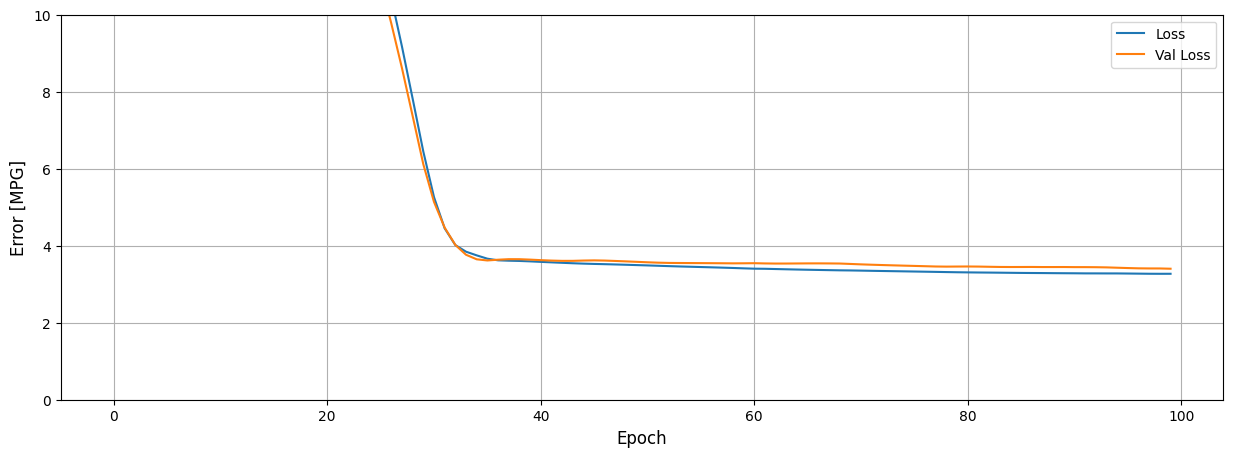

In [34]:
plot_loss(history_dnn_1d)

### 5.4 Visualize the Fitted Model

As you can see in the plot below, we now have a non-linear response from the neural network. In the next section we are going to add a second input feature so we an visualize the non-linear response in more than two dimensions.

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


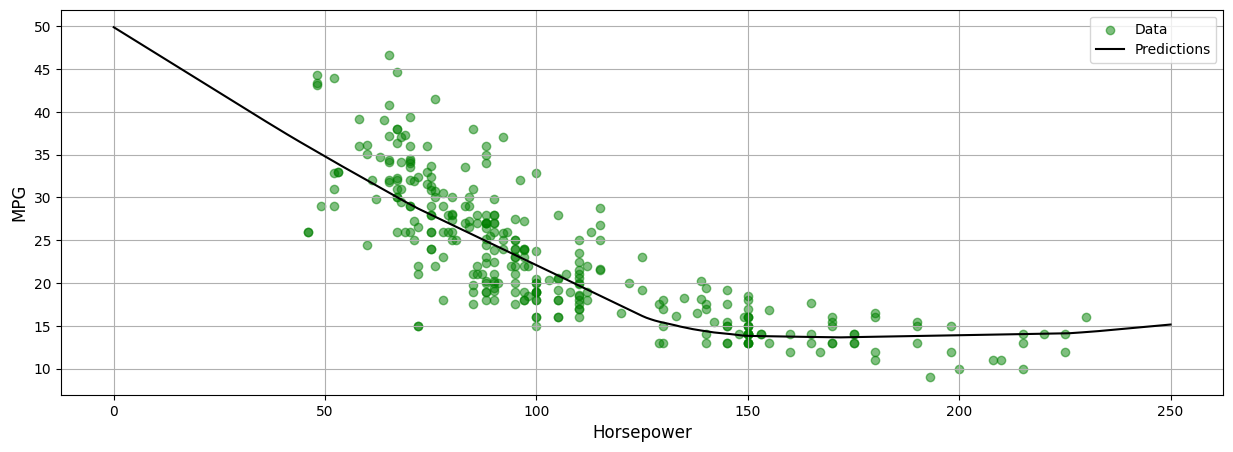

In [35]:
x = tf.linspace(0.0, 250, 251)
y = dnn_1d_model.predict(x)

plot_horsepower(x, y)

## 6 Deep Learning with Multiple Features

We will now introduce a second feature as we did in the Linear Regression section. This time we'll be using two input features with a deep neural network so that we can demonstrate the non-linear behavior of a neural work in more than two dimensions. When we used two input variables with just a single neuron (linear regression) the response function was a 2D plane in 3D space. This time we expect a non-linear surface in 3D space that better fits the data. Let's continue on and see!

### 6.1 Build the Keras Model

The model below is the same as the one in the previous section with the exception that we are using two input features instead of one.

In [36]:
dnn_2d_model = tf.keras.Sequential()
dnn_2d_model.add(hp_dp_normalizer)                # Previously defined.
dnn_2d_model.add(Dense(32, activation='relu'))
dnn_2d_model.add(Dense(32, activation='relu'))
dnn_2d_model.add(Dense(1, activation=None))
dnn_2d_model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ normalization_1 (Normalization)      │ (None, 2)                   │               5 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 32)                  │              96 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,190 (4.65 KB)

 Trainable params: 1,185 (4.63 KB)

 Non-trainable params: 5 (24.00 B)

### 6.2 Compile the Model

In [37]:
dnn_2d_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.001),
    loss='mae')

### 6.3 Train the Model

In [38]:
history_dnn_2d = dnn_2d_model.fit(
    X_train[['Horsepower', 'Displacement']],
    y_train,
    epochs=100,
    verbose=0,
    validation_split = 0.3)

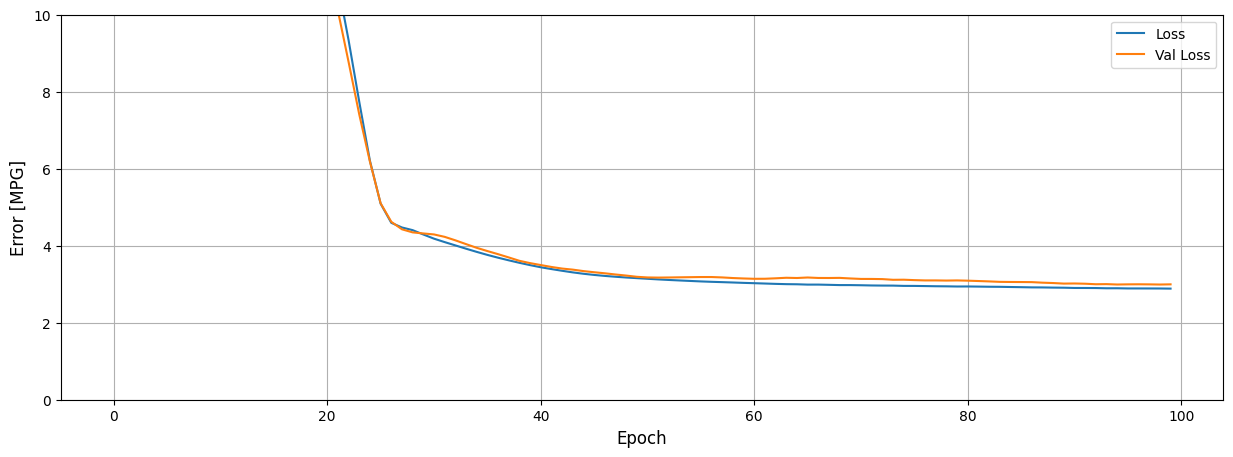

In [39]:
plot_loss(history_dnn_2d)

### 6.4 Visualize the Fitted Model

As shown in the plots below the response function from the network is a non-linear surface which does a better job of fitting the data.

In [40]:
hp_min = X_train.Horsepower.min()
hp_max = X_train.Horsepower.max()
dp_min = X_train.Displacement.min()
dp_max = X_train.Displacement.max()

x_surf, y_surf = np.meshgrid(np.linspace(hp_min, hp_max, 100), np.linspace(dp_min, dp_max, 100))
x_grid = pd.DataFrame({'Horsepower': x_surf.ravel(), 'Displacement': y_surf.ravel()})

pred_y = dnn_2d_model.predict(x_grid)
pred_y = np.array(pred_y)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


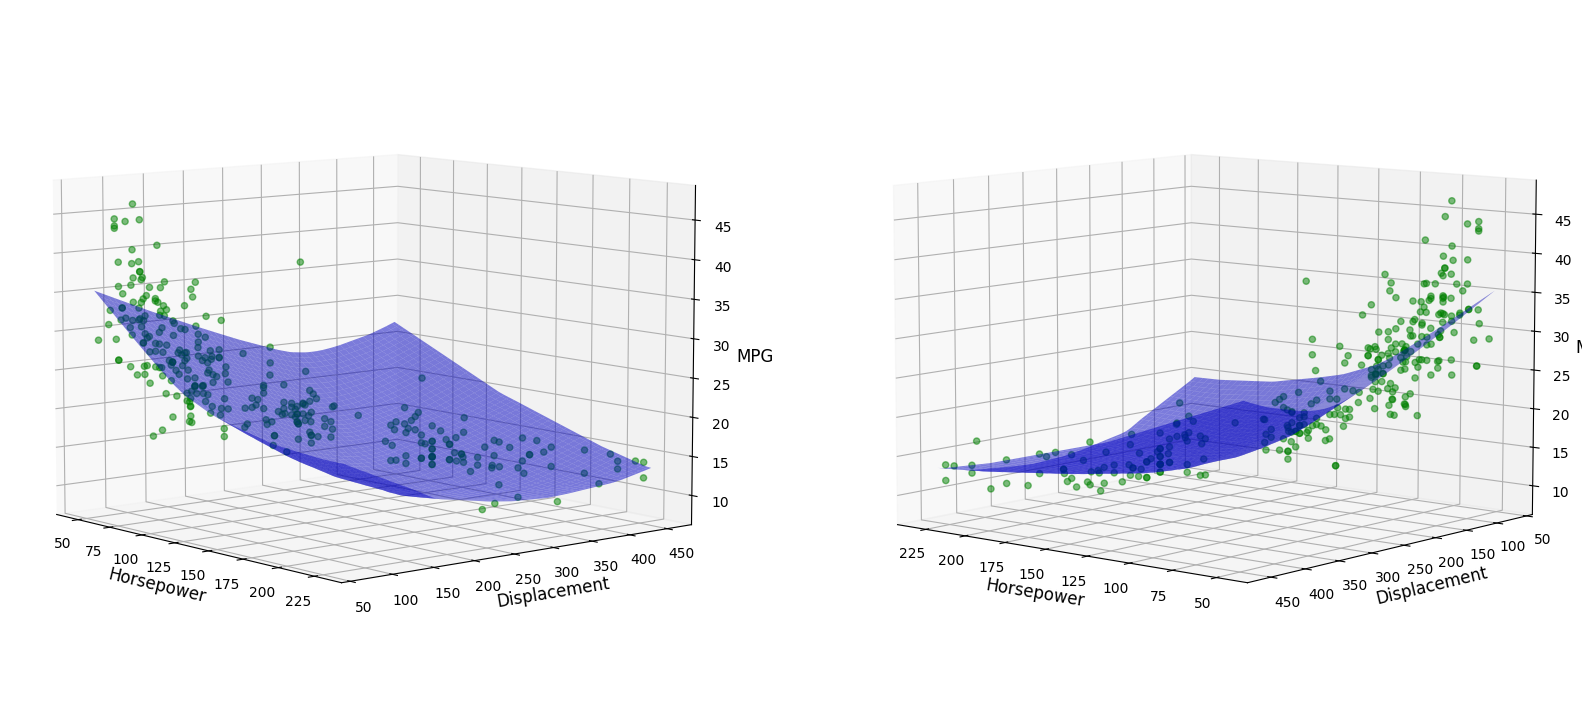

In [41]:
fig = plt.figure(figsize=(20, 10))

ax = fig.add_subplot(121, projection='3d')
ax.scatter(X_train['Horsepower'], X_train['Displacement'], y_train, c='green',  marker='o', alpha=0.5)
ax.plot_surface(x_surf, y_surf, pred_y.reshape(x_surf.shape), color='blue', alpha=0.5)
ax.set_xlabel('Horsepower')
ax.set_ylabel('Displacement')
ax.set_zlabel('MPG')
ax.view_init(8, -40)

ax = fig.add_subplot(122, projection='3d')
ax.scatter(X_train['Horsepower'], X_train['Displacement'], y_train, c='green', marker='o', alpha=0.5)
ax.plot_surface(x_surf, y_surf, pred_y.reshape(x_surf.shape), color='blue', alpha=0.5)
ax.set_xlabel('Horsepower')
ax.set_ylabel('Displacement')
ax.set_zlabel('MPG')
ax.view_init(8, 130)

## 7 Model Comparison

Let's now compare each of the four models that we developed. We can quickly evaluate the models on the test data using `model.evaluate()`. This function will return the mean absolute error associated with the test data for each model. As expected, the test error for each model is progressively lower as we introduce additional features and non-linearity.

### 7.1 Compare Training Loss Curves

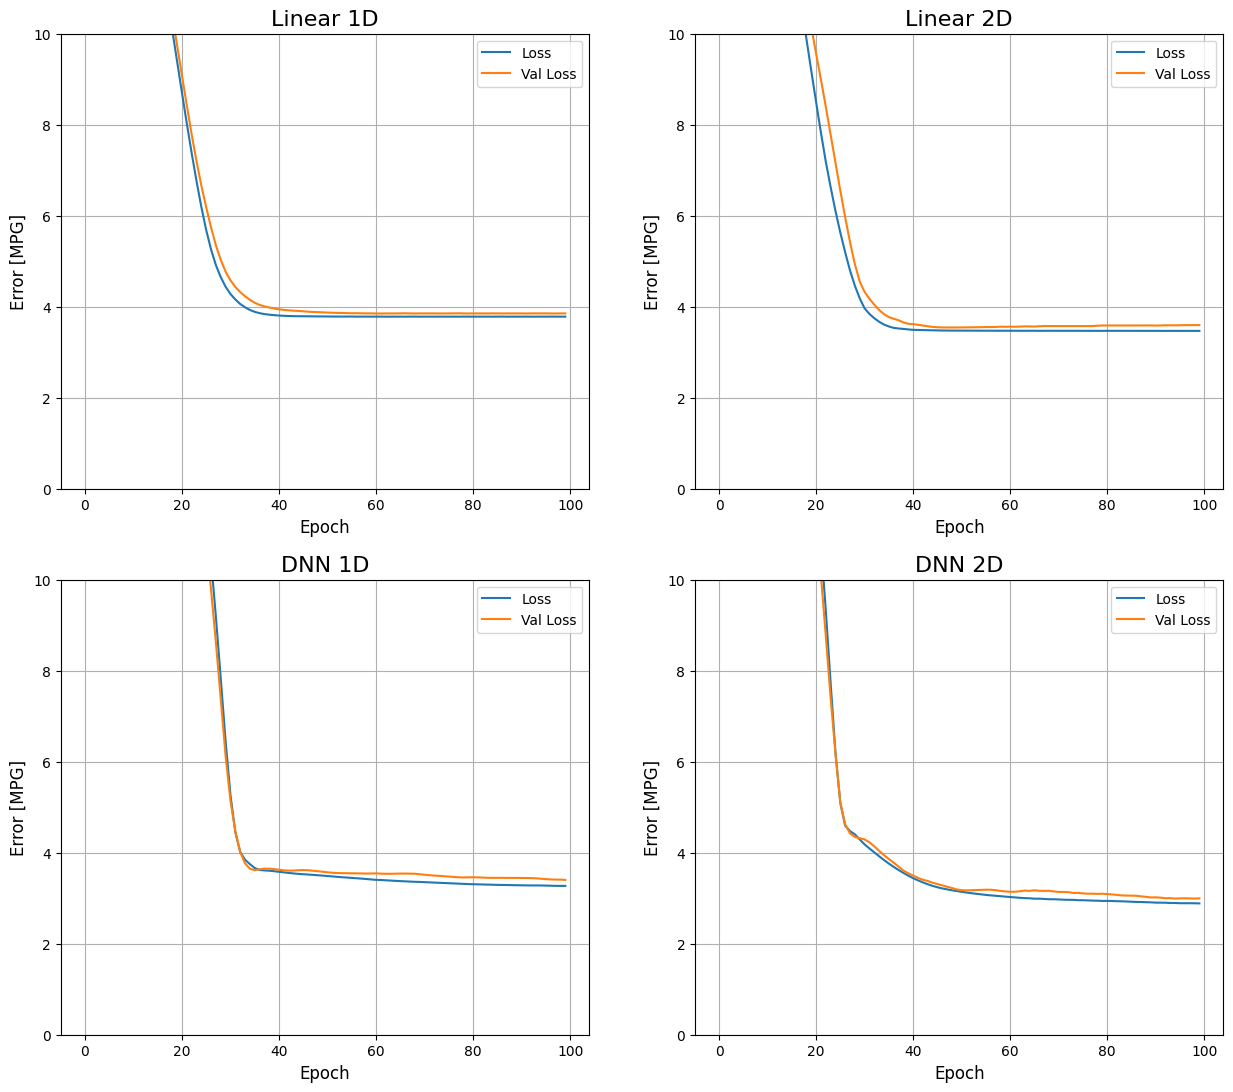

In [42]:
plt.figure(figsize=(15, 13))
plt.subplot(2,2,1)
plt.plot(history_linear_1d.history['loss'], label='Loss')
plt.plot(history_linear_1d.history['val_loss'], label='Val Loss')
plt.ylim([0, 10])
plt.xlabel('Epoch')
plt.ylabel('Error [MPG]')
plt.title('Linear 1D')
plt.legend()
plt.grid(True)

plt.subplot(2,2,2)
plt.plot(history_linear_2d.history['loss'], label='Loss')
plt.plot(history_linear_2d.history['val_loss'], label='Val Loss')
plt.ylim([0, 10])
plt.xlabel('Epoch')
plt.ylabel('Error [MPG]')
plt.title('Linear 2D')
plt.legend()
plt.grid(True)

plt.subplot(2,2,3)
plt.plot(history_dnn_1d.history['loss'], label='Loss')
plt.plot(history_dnn_1d.history['val_loss'], label='Val Loss')
plt.ylim([0, 10])
plt.xlabel('Epoch')
plt.ylabel('Error [MPG]')
plt.title('DNN 1D')
plt.legend()
plt.grid(True)

plt.subplot(2,2,4)
plt.plot(history_dnn_2d.history['loss'], label='Loss')
plt.plot(history_dnn_2d.history['val_loss'], label='Val Loss')
plt.ylim([0, 10])
plt.xlabel('Epoch')
plt.ylabel('Error [MPG]')
plt.title('DNN 2D')
plt.legend()
plt.grid(True)

### 7.2 Model Evaluation Comparison

In [43]:
# Create a dictionary to store test results.
test_results = {}

# Linear regression test results.
test_results['linear_1d_model'] = linear_1d_model.evaluate(X_test['Horsepower'], y_test, verbose=0)
test_results['linear_2d_model'] = linear_2d_model.evaluate(X_test[['Horsepower', 'Displacement']],
                                                            y_test, verbose=0)
# Deep learning regression test results.
test_results['dnn_1d_model']    = dnn_1d_model.evaluate(X_test['Horsepower'], y_test, verbose=0)
test_results['dnn_2d_model']    = dnn_2d_model.evaluate(X_test[['Horsepower', 'Displacement']],
                                                            y_test, verbose=0)

In [44]:
pd.DataFrame(test_results, index=['Mean Absolute Error [MPG]']).T

,Mean Absolute Error [MPG]
linear_1d_model,4.014925
linear_2d_model,3.569829
dnn_1d_model,3.540529
dnn_2d_model,2.981940


### 7.3 Visualizing Model Predictions

Let's now take a look at how well the final model (`dnn_2d_model`) predicts vehicle MPG based on two input features.

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


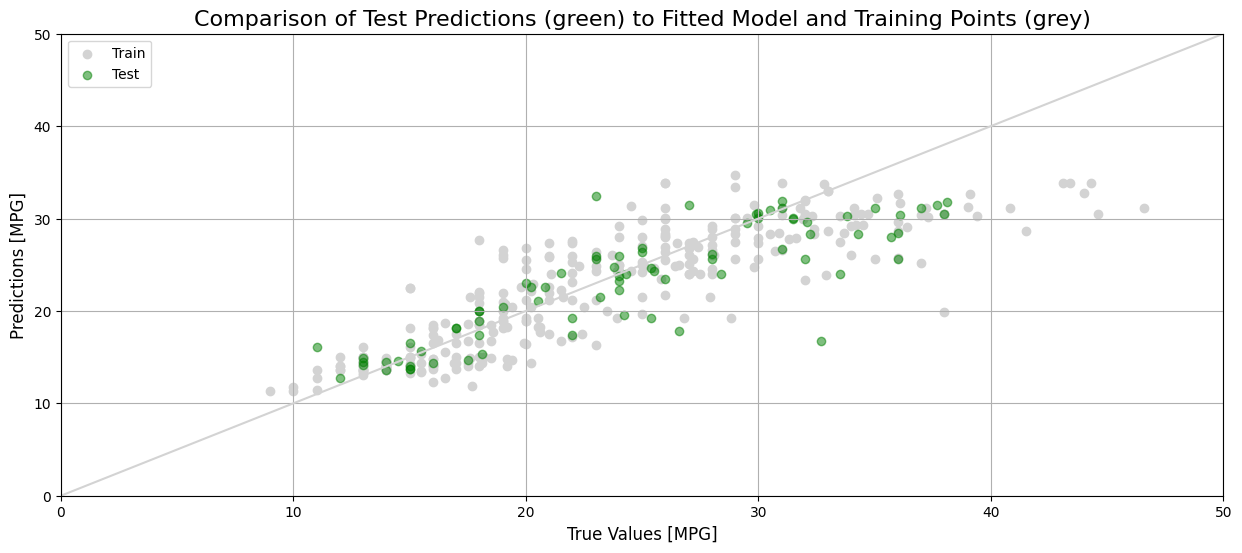

In [45]:
train_predictions = dnn_2d_model.predict(X_train[['Horsepower', 'Displacement']]).flatten()
test_predictions = dnn_2d_model.predict(X_test[['Horsepower', 'Displacement']]).flatten()

plt.scatter(y_train, train_predictions, c='lightgray')
plt.scatter(y_test, test_predictions, c='green', alpha=.5)
plt.title('Comparison of Test Predictions (green) to Fitted Model and Training Points (grey)')
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
plt.legend(['Train', 'Test'])
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
plt.grid('on')
plt.plot(lims, lims, c='lightgray');

We can also compute the Mean Absolute Error (MAE) manually from the test data.

In [46]:
test_error = test_predictions - y_test

mae = sum(abs(test_error))/len(y_test)
print('MAE for dnn_2d_model: ', int(mae*10000)/10000)

MAE for dnn_2d_model:  2.9819


### 7.4 Test Error Distribution

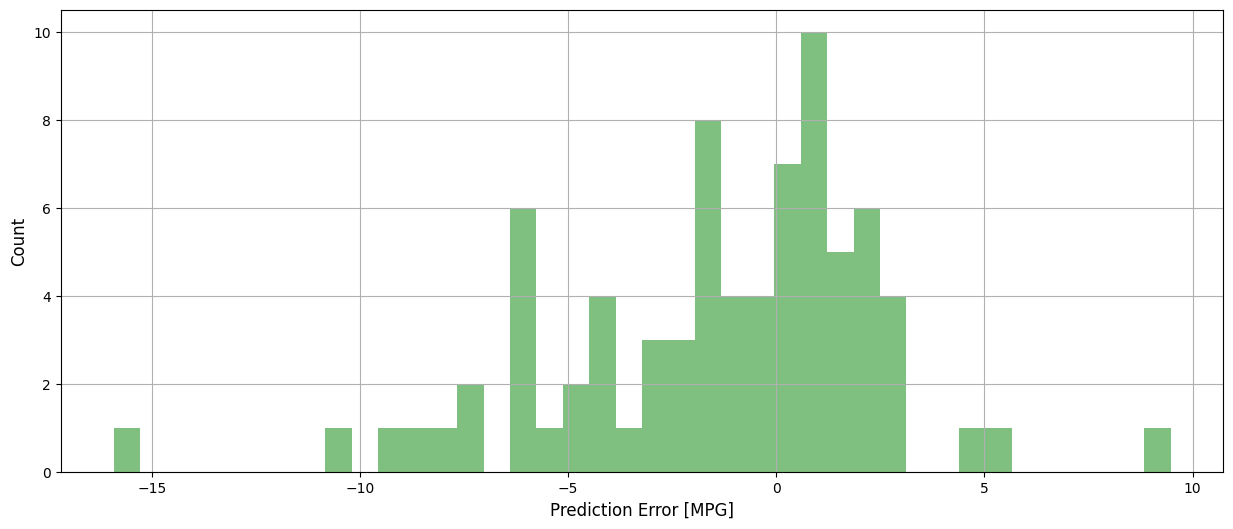

In [47]:
plt.hist(test_error, bins=40, color='green', alpha=.5)
plt.xlabel('Prediction Error [MPG]')
plt.grid('on')
plt.ylabel('Count');

## 8 Conclusion

In this first part of this notebook, we learned how to model linear regression using a neuron (with a linear activation function), which can be thought of as a simple linear neural network with a single layer (the output layer). We showed that the response from the network is a linear function. We looked at two examples with a single input feature and two input features and showed that these correspond to response functions of a straight line and 2D plane, respectively. In higher dimensions (when the number of features exceeds 2), the response from the linear regression model becomes a hyperplane that cannot be visualized.

Next, we explored the use of hidden layers and non-linear activation functions in a neural network. We showed that this type of architecture allows the network to learn non-linear mappings between the inputs and the output. We showed examples for both a single input feature and two input features to visualize the non-linear response functions. This can easily be extended to using all the features in the dataset. Although it would not be possible to visualize the response function in higher dimensions, you should expect slightly better predictions when using more features. This would be a good exercise to experiment with on your own.

Much of what we have covered here also applies to classification problems as we will see later in this module.